In [1]:
import numpy as np

from sklearn.neighbors import KernelDensity as KDE, DistanceMetric
from sklearn.cluster import KMeans, AgglomerativeClustering as HC
from sklearn.metrics import silhouette_score as SC, normalized_mutual_info_score as NMI
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt

In [2]:
def data_preprocessing(X_raw,y_raw):
    X_raw = X_raw.reshape(-1,X_raw.shape[1]*X_raw.shape[2])
    y_label = np.where(y_raw == 1)[1]
    
    y_label_0 = np.where(y_label==0)[0]
    y_label_1 = np.where(y_label==1)[0]
    y_label_2 = np.where(y_label==2)[0]
    
    X_0 = X_raw[y_label_0,:]
    y_0 = np.zeros((X_0.shape[0],1))
    X_1 = X_raw[y_label_1,:]
    y_1 = np.ones((X_1.shape[0],1))
    X_2 = X_raw[y_label_2,:]
    y_2 = 2*np.ones((X_2.shape[0],1))
    
    data_0 = np.concatenate((X_0,y_0),axis=1)
    data_1 = np.concatenate((X_1,y_1),axis=1)
    data_2 = np.concatenate((X_2,y_2),axis=1)
    data = np.concatenate((data_0,data_1,data_2),axis=0)
    
    np.random.shuffle(data)
    
    X = data[:,:-1]
    y = data[:,-1]
    
    return X,y

In [3]:
path='HomeworkData/'
data = np.load(path+'mnist.npz')
X_test_raw = data['X_test']
y_test_raw = data['y_test']
X_test, y_test = data_preprocessing(X_test_raw,y_test_raw)

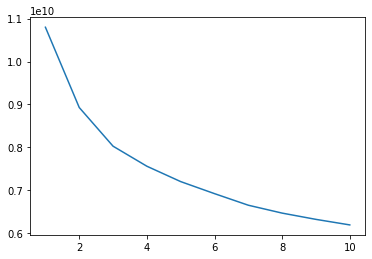

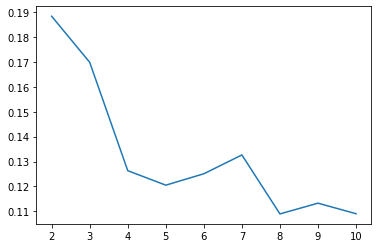

In [4]:
sse_scores = np.zeros(10)
sc_scores = np.zeros(9)

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,random_state=26).fit(X_test)
    sse_scores[i-1] = kmeans.inertia_
    labels = kmeans.labels_
    if i > 1:
        sc_scores[i-2] = SC(X_test, labels, random_state=26)

plt.plot(np.arange(1,11),sse_scores)
plt.show()
plt.plot(np.arange(2,11),sc_scores)
plt.show()

In [6]:
# 观察数据点间欧式距离，确定密度半径
dists = DistanceMetric.get_metric('euclidean')
upper = (np.triu(dists.pairwise(X_test),1)).ravel()
dists_nonz = upper[upper > 0]
dists_nonz.sort()
print(dists_nonz[:200])

[273.43920714 306.72789244 307.41665537 307.99188301 311.17840542
 314.23558042 319.31019401 329.2172535  329.40856091 330.81112436
 331.17970952 331.97138431 335.3923076  336.15175145 336.71798289
 337.15426736 339.2565401  339.39799646 340.55983322 340.67873429
 341.26382756 341.76014981 342.59305305 342.88044564 344.88548824
 347.50683447 350.06427981 352.98725189 353.90535458 356.66510903
 358.15639042 358.43548931 358.51080876 358.82725649 359.16848414
 359.67624331 360.00694438 360.07221498 360.90303407 361.14955351
 361.15647578 361.29766122 362.20988391 362.72854864 363.2602373
 363.28501208 363.69355232 364.50240054 364.64229047 365.24786105
 365.64737111 365.82782836 366.25264504 367.02316003 367.94972483
 368.14806804 368.18745226 368.67872192 368.79398043 369.1490214
 369.81481852 371.72436025 371.9919354  373.52777674 374.20849803
 374.60245594 375.26523953 375.48368806 376.04653967 376.77181423
 376.93102817 376.98806347 377.28636339 377.64401227 379.38239284
 379.4469659

In [7]:
def density_method(X, n_clusters, bandwidth):
    kde = KDE(bandwidth=bandwidth, kernel='tophat').fit(X)
    kde_prob = np.argsort(np.exp(kde.score_samples(X)))[::-1]
    kde_maxs = X[kde_prob[0],:].reshape(1,-1)
    
    for i in range(1,len(kde_prob)):
        kde_max_append = X[kde_prob[i],:].reshape(1,-1)
        dists = euclidean_distances(kde_maxs,kde_max_append)
        if np.amin(dists) < bandwidth:
            continue
        kde_maxs = np.concatenate((kde_maxs,kde_max_append),axis=0)
        if kde_maxs.shape[0] == n_clusters:
            break
        if i == len(kde_prob)-1:
            raise ValueError('Centroids are too near, please try smaller bandwidth.')
    
    return kde_maxs

In [8]:
def init_comparison(X_test, y_test, n_clusters, n_trials, bandwidth):
    nmi = np.zeros(3)
    kde_init = density_method(X_test, n_clusters, bandwidth)
    
    for i in range(n_trials):
        kmeans_1 = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, max_iter=50).fit(X_test)
        nmi[0] += NMI(y_test, kmeans_1.labels_)
        kmeans_2 = KMeans(n_clusters=n_clusters, init='random', n_init=1, max_iter=50).fit(X_test)
        nmi[1] += NMI(y_test, kmeans_2.labels_)
        kmeans_3 = KMeans(n_clusters=n_clusters, init=kde_init, n_init=1, max_iter=50).fit(X_test)
        nmi[2] += NMI(y_test, kmeans_3.labels_)

    nmi /= n_trials    
    print('nmi averages:')
    print('k-means++:', nmi[0])
    print('random:', nmi[1])
    print('density:', nmi[2])

In [9]:
init_comparison(X_test, y_test, n_clusters=3, n_trials=3, bandwidth=350)#350效果最优

nmi averages:
k-means++: 0.748049351926793
random: 0.7495687078224348
density: 0.7477255648556748


In [10]:
def hc_comparison(X_test, y_test, n_clusters):
    hc_11 = HC(n_clusters=n_clusters,affinity='euclidean',linkage='single').fit_predict(X_test) 
    hc_12 = HC(n_clusters=n_clusters,affinity='euclidean',linkage='average').fit_predict(X_test)
    hc_13 = HC(n_clusters=n_clusters,affinity='euclidean',linkage='complete').fit_predict(X_test)

    hc_21 = HC(n_clusters=n_clusters,affinity='manhattan',linkage='single').fit_predict(X_test)
    hc_22 = HC(n_clusters=n_clusters,affinity='manhattan',linkage='average').fit_predict(X_test)
    hc_23 = HC(n_clusters=n_clusters,affinity='manhattan',linkage='complete').fit_predict(X_test)

    hc_31 = HC(n_clusters=n_clusters,affinity='cosine',linkage='single').fit_predict(X_test)
    hc_32 = HC(n_clusters=n_clusters,affinity='cosine',linkage='average').fit_predict(X_test)
    hc_33 = HC(n_clusters=n_clusters,affinity='cosine',linkage='complete').fit_predict(X_test)

    print('nmi averages:')
    print('affinity = euclidean:')
    print('\tlinkage = single:', NMI(y_test, hc_11))
    print('\tlinkage = average:', NMI(y_test, hc_12))
    print('\tlinkage = complete:', NMI(y_test, hc_13))
    print('affinity = manhattan:')
    print('\tlinkage = single:', NMI(y_test, hc_21))
    print('\tlinkage = average:', NMI(y_test, hc_22))
    print('\tlinkage = complete:', NMI(y_test, hc_23))
    print('affinity = cosine:')
    print('\tlinkage = single:', NMI(y_test, hc_31))
    print('\tlinkage = average:', NMI(y_test, hc_32))
    print('\tlinkage = complete:', NMI(y_test, hc_33))

In [11]:
hc_comparison(X_test, y_test, n_clusters=3)

nmi averages:
affinity = euclidean:
	linkage = single: 0.0012861646727329432
	linkage = average: 0.0038319082476843
	linkage = complete: 0.4024000777847923
affinity = manhattan:
	linkage = single: 0.0012861646727329432
	linkage = average: 0.004463767961463452
	linkage = complete: 0.5012809886649041
affinity = cosine:
	linkage = single: 0.0012861646727329432
	linkage = average: 0.5157251246336864
	linkage = complete: 0.42037008340277876
